In [ ]:
#importing
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
#read data file and check types
df = pd.read_csv('data.csv')
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [ ]:
#numeric columns
df.describe(include=['number'])

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [ ]:
#ovject columns
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,4/13/2016,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


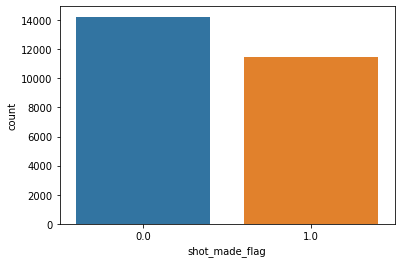

In [ ]:
#graph fortotal missed shots and field goals
sns.countplot(df.shot_made_flag)

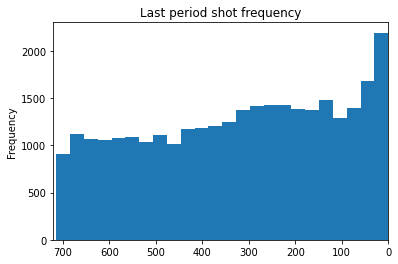

In [ ]:
#shot frequency graph
df['time_remaining'] = 60 * df.loc[:, 'minutes_remaining'] + df.loc[:, 'seconds_remaining']
df['time_remaining'].plot(kind='hist', bins=24, xlim=(720, 0), title='Last period shot frequency')

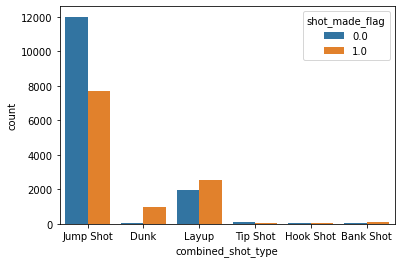

In [ ]:
#shot type chart
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=df)

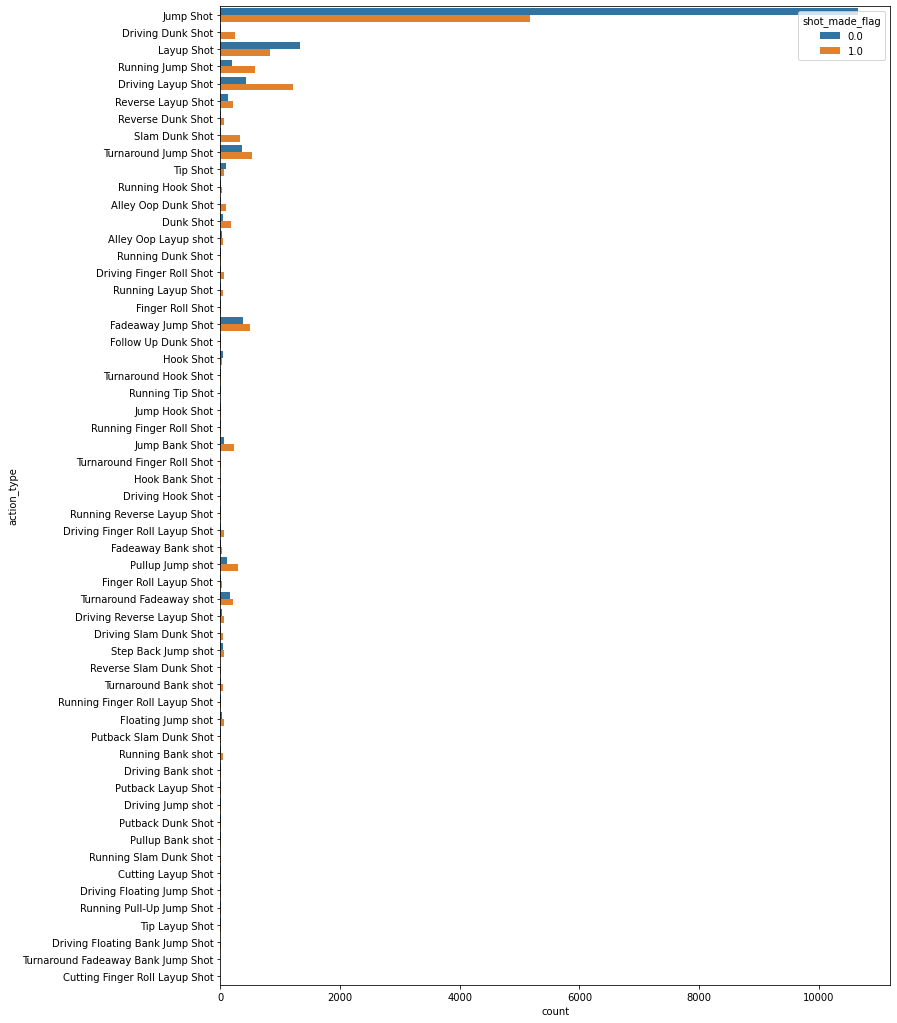

In [ ]:
#total number of shots by shooting type
plt.figure(figsize=(12,18))
sns.countplot(y="action_type", hue="shot_made_flag", data=df)

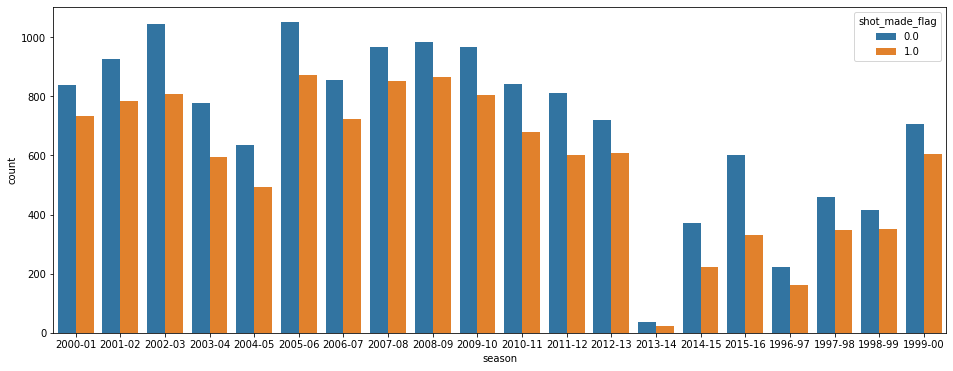

In [ ]:
#total shots number by season
plt.figure(figsize=(16,6))
sns.countplot(x="season", hue="shot_made_flag", data=df)

Text(0.5, 1.0, 'lat and lon')

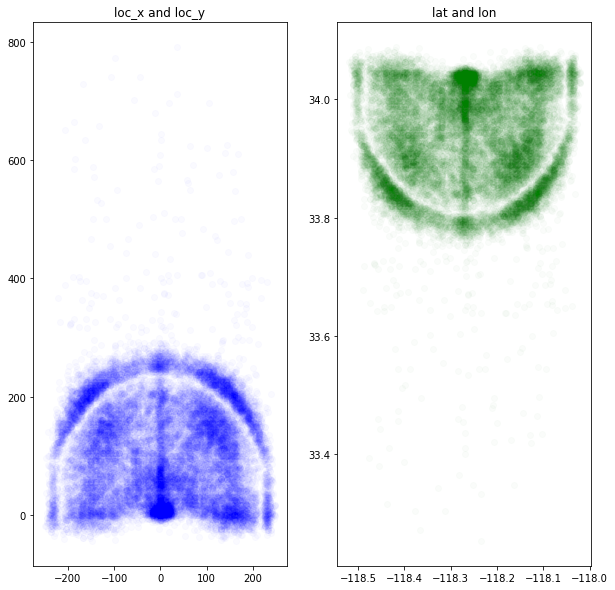

In [ ]:
#exploring loc_x and loc_y and lat and lon
nona =  df[pd.notnull(df['shot_made_flag'])]
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.scatter(nona.loc_x, nona.loc_y, color='blue', alpha=0.02)
plt.title('loc_x and loc_y')

plt.subplot(122)
plt.scatter(nona.lon, nona.lat, color='green', alpha=0.02)
plt.title('lat and lon')

In [ ]:
#making a copy
data_copy = df.copy()
result = data_copy['shot_made_flag'].copy()

#dropping unrelated and independent columns
data_copy.drop(['team_id','team_name'], axis=1, inplace=True) # Always one number
data_copy.drop(['lat', 'lon'], axis=1, inplace=True) # Correlated with loc_x
data_copy.drop(['game_id','game_event_id'], axis=1, inplace=True) # Independent

#convert time and drop the two original columns
data_copy['time_remaining'] = 60 * data_copy['minutes_remaining'] + data_copy['seconds_remaining']
data_copy.drop(['minutes_remaining','seconds_remaining'], axis=1, inplace=True)

#converting game date to year, month
data_copy['game_date'] = pd.to_datetime(data_copy['game_date'])
data_copy['game_year'] = data_copy['game_date'].dt.year
data_copy['game_month'] = data_copy['game_date'].dt.month
data_copy.drop('game_date', axis=1, inplace=True)

#converting matchup to home_play
data_copy['home_play'] = data_copy['matchup'].apply(lambda x: 1 if 'vs' in x else 0)
data_copy.drop('matchup', axis=1, inplace=True)

#recheck
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   loc_x               30697 non-null  int64  
 3   loc_y               30697 non-null  int64  
 4   period              30697 non-null  int64  
 5   playoffs            30697 non-null  int64  
 6   season              30697 non-null  object 
 7   shot_distance       30697 non-null  int64  
 8   shot_made_flag      25697 non-null  float64
 9   shot_type           30697 non-null  object 
 10  shot_zone_area      30697 non-null  object 
 11  shot_zone_basic     30697 non-null  object 
 12  shot_zone_range     30697 non-null  object 
 13  opponent            30697 non-null  object 
 14  shot_id             30697 non-null  int64  
 15  time_remaining      30697 non-null  int64  
 16  game

In [ ]:
#generating dummies
cate=['action_type','combined_shot_type','season','opponent','shot_type','period','shot_zone_basic','shot_zone_area','shot_zone_range','game_month']
for x in cate:
        data_copy=pd.concat([data_copy,pd.get_dummies(data_copy[x],prefix=x)], 1)
        data_copy=data_copy.drop(x,1)

In [ ]:
#set up before evaluating
unknown = data_copy['shot_made_flag'].isnull()
data_copy.drop(['loc_x','loc_y'], axis=1, inplace=True)
x = data_copy[~unknown]
y = df.shot_made_flag[~unknown]

In [ ]:
#split the data
x = x.drop(["shot_made_flag"], 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state=9)

#evaluate xgbclassifier model predictions
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
#make predictions for test data
pred = xgb.predict(x_test)
pred_xgb = [round(value) for value in pred]
acc_xgb = accuracy_score(y_test, pred_xgb)
print(acc_xgb)

0.6819985991127714


In [ ]:
#evaluate RandomForestClassifier model predictions
rfc = RandomForestClassifier(n_estimators=1000, max_features="sqrt", min_samples_leaf=50)
rfc.fit(x_train, y_train)
#make predictions for test data
pred_rfc = rfc.predict(x_test)
pred_rfc1 = [np.round(value) for value in pred_rfc]
acc_rfc = accuracy_score(y_test, pred_rfc1)
print(acc_rfc)

0.6764728772667133


In [ ]:
#evaluate ExtraTreesClassifier model predictions
etc = ExtraTreesClassifier(n_estimators=100, max_features=10)
etc.fit(x_train, y_train)
#make predictions for test data
pred_etc = etc.predict(x_test)
pred_etc1 = [np.round(value) for value in pred_etc]
acc_etc = accuracy_score(y_test, pred_etc1)
print(acc_etc)

0.6458090123745038


In [ ]:
#xgb have the highest score
final = XGBClassifier()
final.fit(x_train, y_train)
data_test = data_copy[pd.isnull(data_copy['shot_made_flag'])]
data_test = data_test.drop('shot_made_flag', 1)
#make the final prediction
final_data = final.predict_proba(data_test)[:,1]

In [ ]:
#import the final submmision file
upload_sample = files.upload()
sub = pd.read_csv('sample_submission.csv')
#fit the data into the file
sub['shot_made_flag'] = final_data
sub.to_csv('submission.csv', index=False)

Saving sample_submission.csv to sample_submission.csv
